In [1]:
""" AHP_3L_with_sensit_analysis_JobSelectionProblem.py """
import numpy as np
from scipy import stats
from scipy.optimize import root
import matplotlib.pyplot as plt

In [2]:
""" Load all the helper functions """

def renorm_wt(p, k, base_wt):
    """ Renormalize the weights when one weight is change 
        while keeping all the other weights in their original 
        proportions 
    Parameters:
        p = new value between 0 and 1
        k = index between 0 and n-1
        base_wt = base weights
    Returns:
        a renormalized weight vector 
    """
  
    new_wt = base_wt.copy()
    bal_wt = base_wt.sum() - base_wt[k]
    for i, w in enumerate(base_wt):
        if i != k:
            new_wt[i] = (1-p)*base_wt[i]/bal_wt
    new_wt[k] = p
    return new_wt


def AHPmat(A, method='Power'):
    """ Comput AHP matrix A using chosen method
    Parameter:  A = matrix to evaluate
    Returns:    w, lambda_max, CI, CR
    """
    
    RI=(0.58,0.90,1.12,1.24,1.32,1.41,1.45,1.49,1.51,1.54,1.56,1.57,1.58) 

    def Power(A):
        """ Compute the AHP matrix A using Power Iterations method.
            Parameter:  A = matrix to evaluate
            Returns:    w, lambda_max, CI, CR
        """
        gm = stats.gmean(A, axis=1)   # Use RGM method as initial value
        w = gm/gm.sum()
        max_iter= 1000000
        epsilon = 1.E-12
        for iter in range(max_iter):
            w1 = np.dot(A,w)    # w(k+1) = A w(k) 
            w1 = w1/w1.sum()    # normalize w(k+1)
            if all(np.absolute(w1-w) < epsilon):
                w = w1
                break
            w = w1
        lambda_max = (np.dot(A,w)/w).mean()
        n, _ = A.shape
        CI = (lambda_max-n)/(n-1)
        CR = 0 if n==2 else CI/RI[n-3]
        return w, lambda_max, CI, CR
    
    def Algebra(A):
        """ Compute the AHP matrix A using Power Iterations method.
            Parameter:  A = matrix to evaluate
            Returns:    w, lambda_max, CI, CR
        """            
        n, _ = A.shape
        # Solve for lambda such that Det(A - lambda*I) = 0
        sol = root(lambda x: np.linalg.det(A-np.eye(n)*x), n)
        lambda_max = sol.x[0]
        # Find w by solving a set of linear equations M w = b
        # M = A - lambda_max I for first n-1 rows
        M = A - np.eye(n)*lambda_max  
        # Replace the last row with [1, 1..., 1]
        M[n-1] = np.ones(n)
        b = np.append(np.zeros(n-1), [1])  # b = [0, 0, ..., 1]
        w = np.linalg.solve(M,b)
        CI = (lambda_max-n)/(n-1)
        CR = 0 if n == 2 else CI/RI[n-3]
        return w, lambda_max, CI, CR
    
    def RGM(A):
        """ Compute the AHP matrix A using the RGM approximation method.
            Parameter:  A = matrix to evaluate
            Returns:    w, lambda_max, CI, CR
        """           
        n, _ = A.shape
        gm = stats.gmean(A, axis=1)   
        w = gm/gm.sum()
        lambda_max = (np.dot(A,w)/w).mean()
        CI = (lambda_max-n)/(n-1)
        CR = 0 if n==2 else CI/RI[n-3]
        return w, lambda_max, CI, CR
    
    # We just need the w vector
    if method=='Power':
        return Power(A)[0]
    elif method=='Algebra':
        return Algebra(A)[0]
    elif method=='RGM':
        return RGM(A)[0]
    else:
        print("Invalid method chosen")
        exit()

In [3]:
""" Job Selection Problem """
    
G = 'Job Satisfaction'
C = ['Research','Growth','Benefits','Colleages',
     'Location','Reputation']
AL = ['Company A', 'Company B', 'Company C']

# Criteria w.r.t Goal
A0 = np.array([[ 1,  1 ,  1,  4,  1,  1/2 ],
               [ 1,  1,   2,  4,  1,  1/2 ],
               [ 1, 1/2 , 1,  5,  3,  1/2 ],
               [1/4,1/4, 1/5, 1, 1/3, 1/3 ],
               [ 1,   1, 1/3, 3,  1,   1  ],
               [ 2,   2,  2,  3,  1,   1  ]] )

In [4]:
# Compute Criteria weights
u = AHPmat(A0, method='Algebra')
print("Criteria's Weights")
for i, cr in enumerate(C):
    print(f"  {cr:10}: {u[i]:.6f}")

Criteria's Weights
  Research  : 0.158408
  Growth    : 0.189247
  Benefits  : 0.197997
  Colleages : 0.048310
  Location  : 0.150245
  Reputation: 0.255792


In [5]:
# Alternatives wrt Research
A1 = np.array([[ 1, 1/4, 1/2 ],  
               [ 4,  1,    3 ],
               [ 2, 1/3,   1 ]])

# Alternatives wrt Growth
A2 =  np.array([[1, 1/4, 1/5 ], 
                [4,  1,  1/2 ],
                [5,  2,   1  ]])

# Alternatives wrt Benefits
A3 = np.array([[ 1,  3,  1/3 ],
               [1/3, 1,  1/7 ],
               [ 3,  7,   1  ]])

# Alternatives wrt Colleagues
A4 = np.array([[ 1,  1/3,  5 ],
               [ 3,   1,   7 ],
               [1/5, 1/7,  1 ]])

# Alternatives wrt Location
A5 = np.array([[ 1,   1,   7 ],
               [ 1,   1,   7 ],
               [1/7, 1/7,  1 ]])

# Alternatives wrt Reputation      
A6 = np.array([[ 1,   7,   9 ],
               [1/7,  1,   2 ],
               [1/9, 1/2,  1 ]])

In [6]:
# Compute alternatives' weights wrt each criterion
W = np.array([ AHPmat(A, method='Algebra') 
                  for A in [A1, A2, A3, A4, A5, A6] ]).T
print("\nAlternatives' local Weights")
print(W)


Alternatives' local Weights
[[0.1364998  0.09739007 0.24263692 0.27895457 0.46666667 0.79275736]
 [0.62501307 0.33306935 0.08794621 0.649118   0.46666667 0.13122122]
 [0.23848712 0.56954058 0.66941687 0.07192743 0.06666667 0.07602141]]


In [7]:
# Alternative global weights
wG = np.dot(W, u)
print(f"\nAlternatives' global weights wrt {G}")
for i, coy in enumerate(AL):
    print(f"  {coy}: {wG[i]:.6f}")


Alternatives' global weights wrt Job Satisfaction
  Company A: 0.374467
  Company B: 0.314491
  Company C: 0.311042


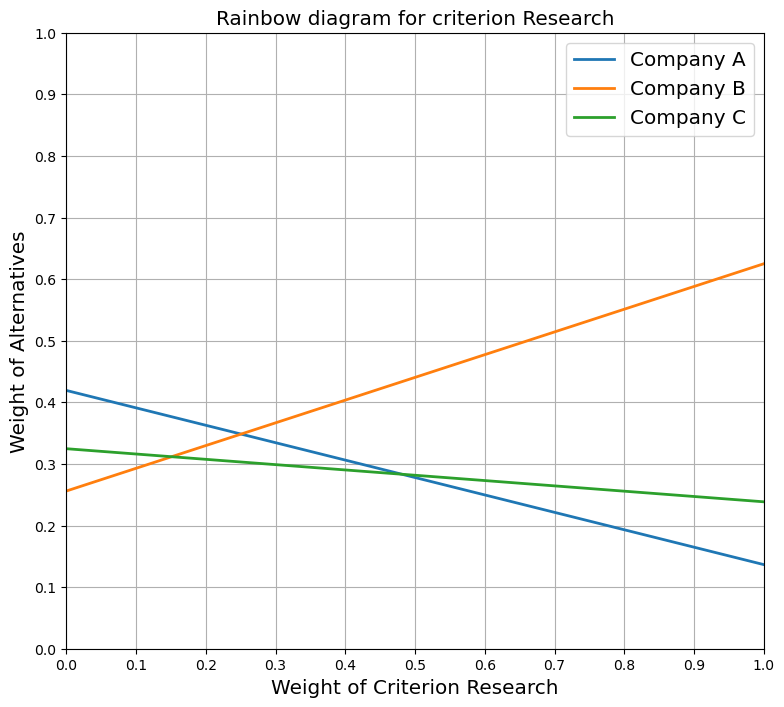

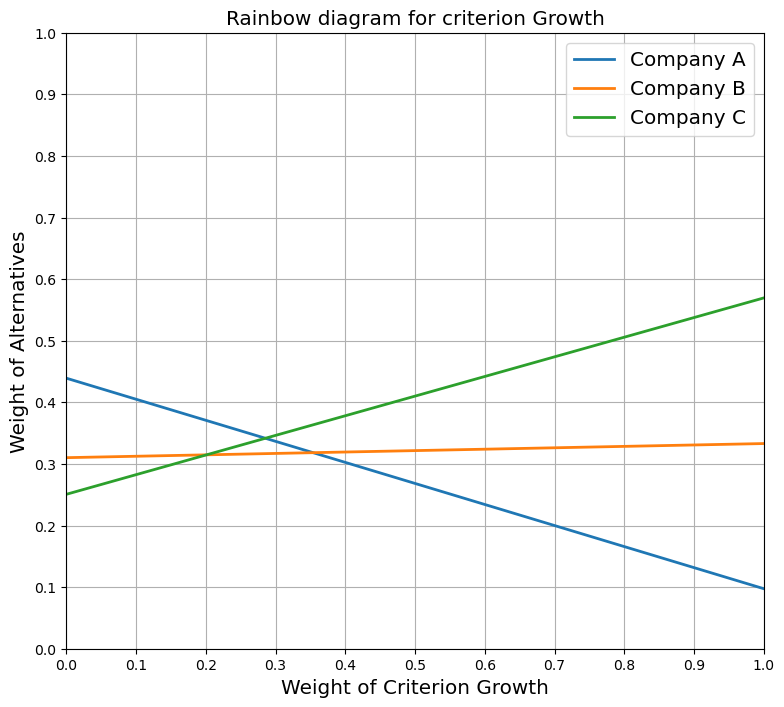

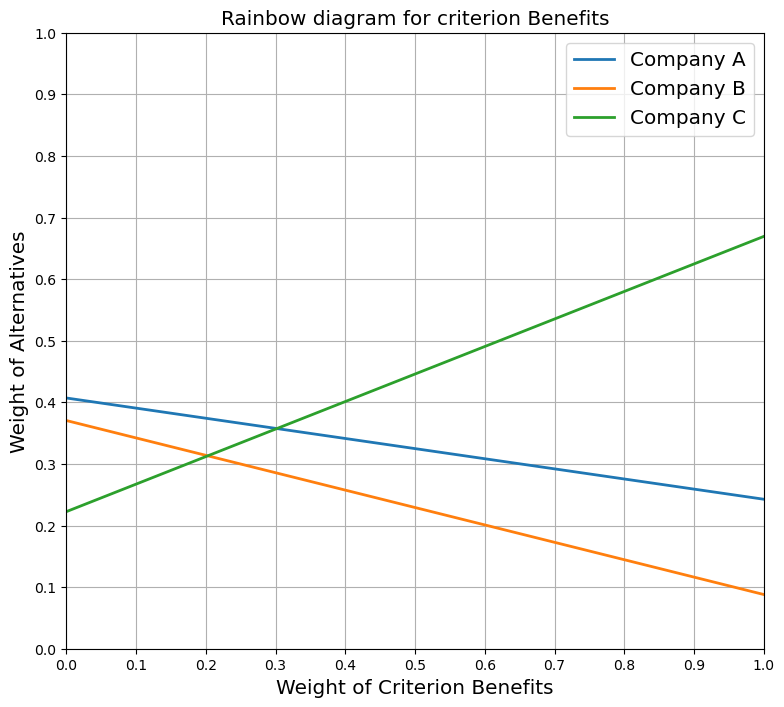

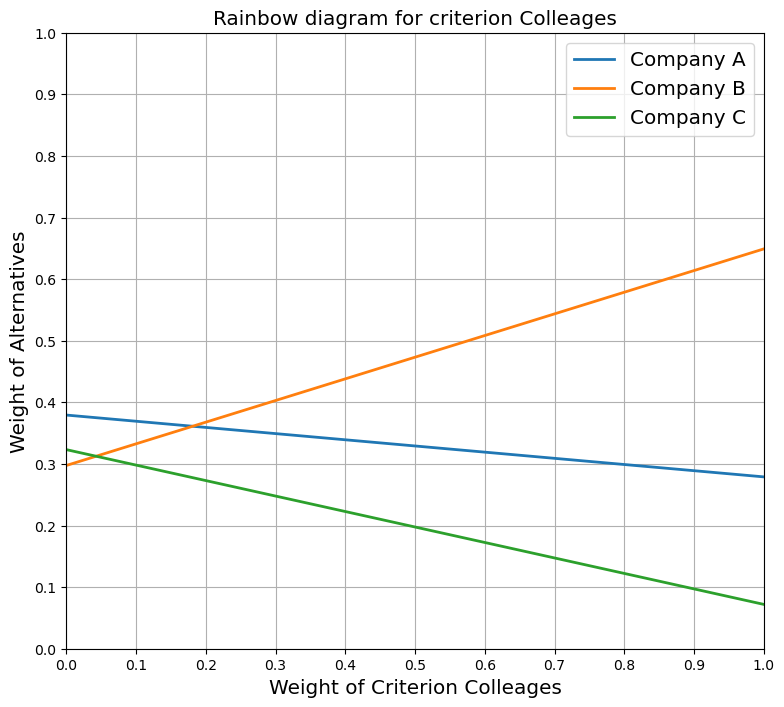

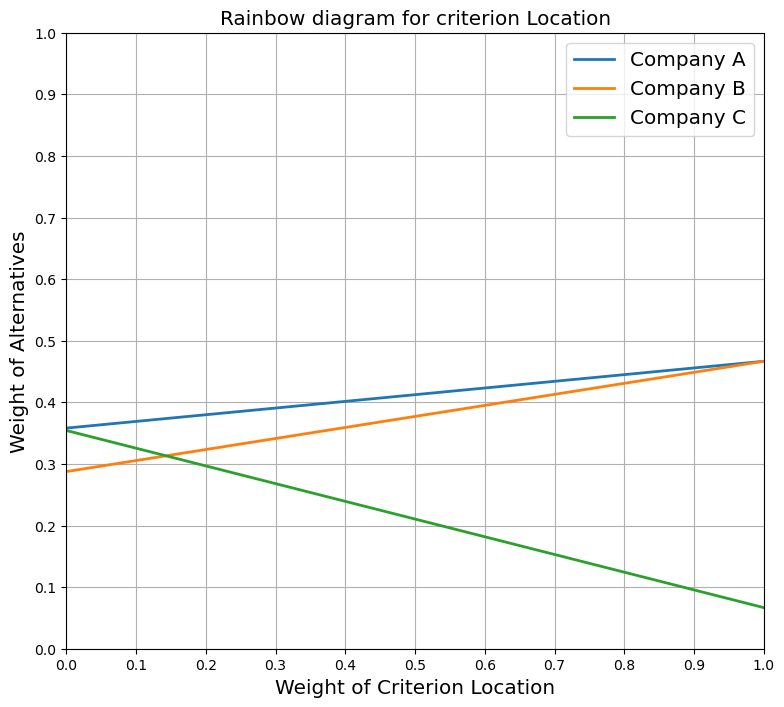

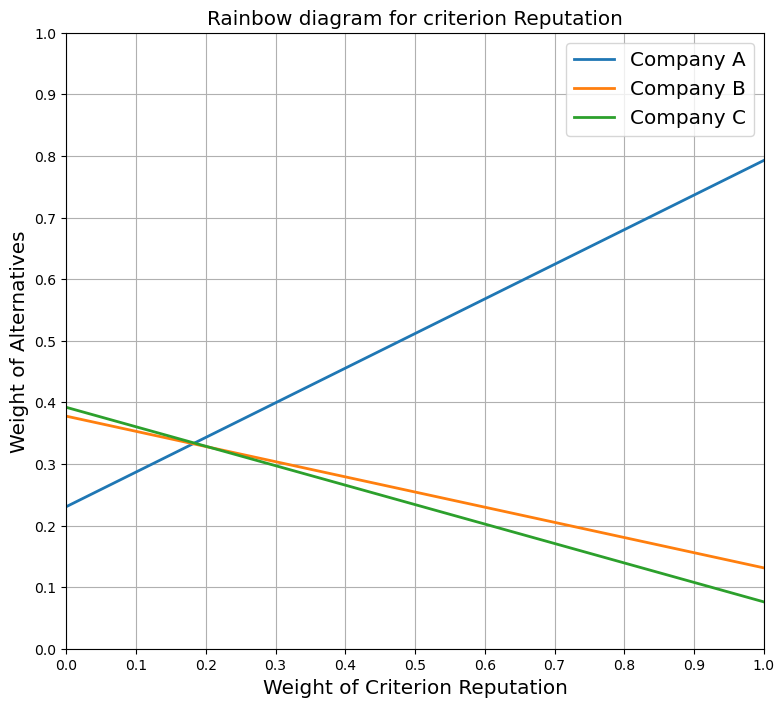

In [8]:
# Sensitivity Analysis
for k, cr in enumerate(C):
    WG_dict = {}
    for p in np.linspace(0,1,11):
        adj_u = renorm_wt(p, k, u)
        WG_dict[p] = np.dot(W, adj_u)
    # Plot the rainbow diagram for criterion cr
    fig, ax = plt.subplots(figsize=(9,8))
    ax.plot(WG_dict.keys(), WG_dict.values(), label=AL, lw='2')
    ax.set_title(f"Rainbow diagram for criterion {cr}", 
                 fontsize='x-large')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xticks(np.linspace(0,1,11))
    ax.set_yticks(np.linspace(0,1,11))
    ax.set_xlabel(f'Weight of Criterion {cr}', fontsize='x-large')
    ax.set_ylabel('Weight of Alternatives', fontsize='x-large')
    ax.legend(fontsize='x-large')
    ax.grid()
    plt.show()